In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet101V2, InceptionResNetV2, MobileNet, InceptionV3
from tensorflow.keras.layers import *
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.backend import *
import seaborn as sns
from datetime import datetime

In [2]:
tf.keras.backend.clear_session()
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:

# Load CSV file with image names and labels
df = pd.read_csv('./dataset/lable.csv')


In [4]:
batch_size=8
# Define the data generator for preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    validation_split=0.2 , # Split dataset into training and validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
size=256
# Create training and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='./dataset/',
    x_col='IMG',
    y_col=['GLM','MNG','NTM','PIT'],
    subset='training',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='raw',  # Use 'raw' for 1-hot encoding
    target_size=(size, size),
    color_mode='grayscale'  
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='./dataset/',
    x_col='IMG',
    y_col=['GLM','MNG','NTM','PIT'],
    subset='validation',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='raw',
    target_size=(size, size),
    color_mode='grayscale'
)


Found 5056 validated image filenames.
Found 1263 validated image filenames.


In [5]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break


Data batch shape: (8, 256, 256, 1)
Labels batch shape: (8, 4)


In [12]:
name_model='DenseNet121'
from models import InceptionNet
model=DenseNet121(weights=None, input_shape=(512,512,1), include_top=False,classes=4)
# for layer in model.layers:
#     layer.trainable=False
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 518, 518, 1)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 3136        zero_padding2d_12[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [7]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(f"./trained models/train_{name_model}.h5", save_best_only=True)


In [8]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)

Epoch 1/50
632/632 [==============================] - 136s 184ms/step - loss: 0.8267 - accuracy: 0.6687 - val_loss: 6.3780 - val_accuracy: 0.0000e+00
Epoch 2/50
632/632 [==============================] - 110s 174ms/step - loss: 0.6863 - accuracy: 0.7352 - val_loss: 3.6923 - val_accuracy: 0.0016
Epoch 3/50
632/632 [==============================] - 111s 175ms/step - loss: 0.6319 - accuracy: 0.7551 - val_loss: 5.0124 - val_accuracy: 0.0000e+00
Epoch 4/50
632/632 [==============================] - 113s 179ms/step - loss: 0.5595 - accuracy: 0.7900 - val_loss: 4.6212 - val_accuracy: 0.0000e+00
Epoch 5/50
632/632 [==============================] - 115s 183ms/step - loss: 0.5256 - accuracy: 0.8048 - val_loss: 3.6713 - val_accuracy: 0.0024
Epoch 6/50
632/632 [==============================] - 111s 176ms/step - loss: 0.4985 - accuracy: 0.8139 - val_loss: 6.7787 - val_accuracy: 0.0000e+00
Epoch 7/50
632/632 [==============================] - 111s 176ms/step - loss: 0.4476 - accuracy: 0.8368 - va

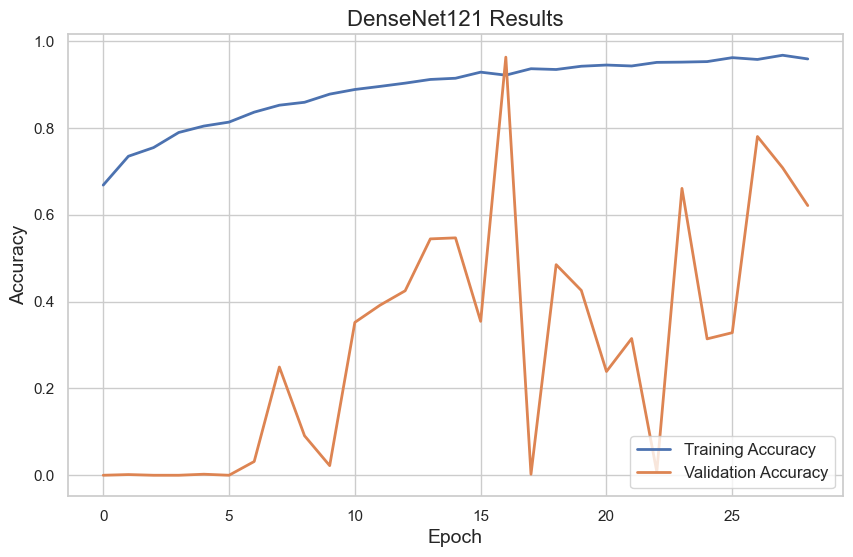

In [9]:
history = model.fit(train_generator,epochs=50,validation_data=valid_generator, batch_size=batch_size, shuffle=True,callbacks=[model_checkpoint, early_stopping])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title(f"{name_model} Results", fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()


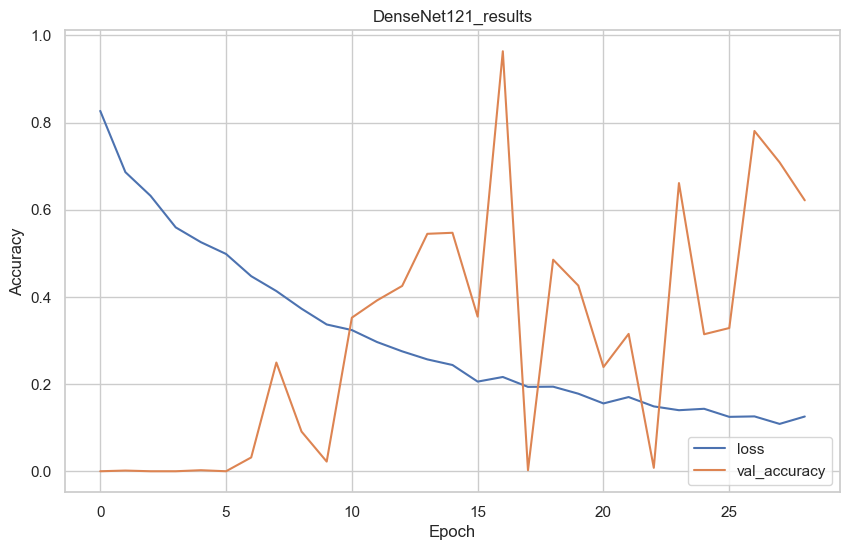

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"{name_model}_results")
plt.legend(loc='lower right')
plt.show()

In [13]:
hist_df = pd.DataFrame(history.history) 

hist_csv_file = f'./training_results/{name_model}_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
print('created csv file')
print(f'cell executeted on :{datetime.now}')

created csv file
cell executeted on :<built-in method now of type object at 0x00007FFAE59A2650>
